In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy.stats import zscore

In [83]:
train = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\unknown_poutcome\\train.csv')
test = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\unknown_poutcome\\test.csv')
submit = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\unknown_poutcome\\head_submit_sample.csv')
poutcome = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\unknown_poutcome\\df_poutcome.csv')

In [84]:
train = train.drop(['poutcome'],axis = 1)

In [85]:
train = pd.concat([train,poutcome], axis = 1)

In [86]:
# jobのunknownの処理
test.replace({'job': {'unknown':'blue-collar'}}, inplace=True)

In [87]:
#score列の作成
train['score'] = np.zeros(train.shape[0])


#個人ローン
#学習データ
loan_none = train.loc[train['loan'] == 'no']
index = loan_none.index.values
index = list(index)

for i in index:
    train.iloc[i,18] = 1
    


#住宅ローン
housing_none = train.loc[train['housing'] == 'no']
index = housing_none.index.values
index = list(index)

score_values = housing_none['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['housing']=='no','score'] = i



#債務不履行
default = train.loc[train['default'] == 'yes']


score_values = default['score'].values
score_values = score_values - 3
score_values = list(score_values)

for i in score_values:
    train.loc[train['default']=='yes','score'] = i





#経営者
management = train.loc[train['job'] == 'management']


score_values = management['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='management','score'] = i
    


#管理者
admin = train.loc[train['job'] == 'admin.']


score_values = admin['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='admin.','score'] = i
    



#学生
student = train.loc[train['job'] == 'student']


score_values = student['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='student','score'] = i
    




#失業者
unemployed = train.loc[train['job'] == 'unemployed']


score_values = unemployed['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='unemployed','score'] = i
    
train.loc[train['job'] == 'unemployed']




#定年退職者
retired = train.loc[train['job'] == 'retired']


score_values = retired['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='retired','score'] = i
    

In [88]:
#テストデータ
#score列の作成
test['score'] = np.zeros(test.shape[0])

#個人ローン
loan_none = test.loc[test['loan'] == 'no']
index = loan_none.index.values
index = list(index)

for i in index:
    test.iloc[i,17] = 1



#住宅ローン
housing_none = test.loc[test['housing'] == 'no']

score_values = housing_none['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['housing']=='no','score'] = i



#債務不履行
default = test.loc[test['default'] == 'yes']


score_values = default['score'].values
score_values = score_values - 3
score_values = list(score_values)

for i in score_values:
    test.loc[test['default']=='yes','score'] = i





#経営者
management = test.loc[test['job'] == 'management']


score_values = management['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='management','score'] = i
    


#管理者
admin = test.loc[test['job'] == 'admin.']


score_values = admin['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='admin.','score'] = i
    



#学生
student = test.loc[test['job'] == 'student']


score_values = student['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='student','score'] = i
    




#失業者
unemployed = test.loc[test['job'] == 'unemployed']


score_values = unemployed['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='unemployed','score'] = i
    



#定年退職者
retired = test.loc[test['job'] == 'retired']


score_values = retired['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='retired','score'] = i

In [89]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month']
#LabelEncording
for c in cat_cols:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

In [90]:
train = train.drop(['id','y'],axis=1)
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,failure,other,success,score
0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,0,1,0,0.0
1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,1,1,0,1.0
2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,1,1,0,1.0
3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,1,0,0,0.0
4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,1,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,1,1,1,0,26661,1,0,0,27,7,345,4,425,0,1,1,0,0.0
27096,35,7,1,1,0,42150,1,0,0,27,7,121,1,719,0,1,1,0,0.0
27097,35,7,1,3,0,34531,0,0,0,28,5,177,2,121,0,1,1,0,1.0
27098,30,0,2,1,0,99621,1,0,0,27,7,121,1,100,0,1,1,0,1.0


In [91]:
test = test.drop(['id','poutcome'],axis=1)

In [92]:
train_x1 = train.iloc[:,:15]
train_x1['score']  = train['score']
train_y_f = train['failure']

#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x1))[0]
tr_x,va_x = train_x1.iloc[tr_idx], train_x1.iloc[va_idx]
tr_y,va_y = train_y_f.iloc[tr_idx], train_y_f.iloc[va_idx] 


d_train = xgb.DMatrix(tr_x, label=tr_y)
d_valid = xgb.DMatrix(va_x, label=va_y)

params = {'objective':'multi:softmax','num_class' : 3 ,'silent':1, 'random_state':71, 'eta':0.1}

num_round = 500

watchilist = [(d_train,'train'),(d_valid,'eval')]

model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

accuracy = accuracy_score(va_y, val_pred)
print(accuracy)

[08:04:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.12384	eval-merror:0.13373
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 20 rounds.
[1]	train-merror:0.11798	eval-merror:0.13018
[2]	train-merror:0.11651	eval-merror:0.12723
[3]	train-merror:0.11592	eval-merror:0.12871
[4]	train-merror:0.11419	eval-merror:0.12590
[5]	train-merror:0.11380	eval-merror:0.12561
[6]	train-merror:0.11144	eval-merror:0.12472
[7]	train-merror:0.10888	eval-merror:0.12133
[8]	train-merror:0.10918	eval-merror:0.12118
[9]	train-merror:0.10799	eval-merror:0.12162
[10]	train-merror:0

In [93]:
d_test = xgb.DMatrix(test)
test_pred_f = model.predict(d_test, ntree_limit = model.best_ntree_limit)
test['failure'] = test_pred_f

In [94]:
train_x2 = train.iloc[:,:15]
train_x2['score'] = train['score']
train_y_o = train['other']

#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x2))[0]
tr_x,va_x = train_x2.iloc[tr_idx], train_x2.iloc[va_idx]
tr_y,va_y = train_y_o.iloc[tr_idx], train_y_o.iloc[va_idx] 


d_train = xgb.DMatrix(tr_x, label=tr_y)
d_valid = xgb.DMatrix(va_x, label=va_y)

params = {'objective':'multi:softmax','num_class' : 3 ,'silent':1, 'random_state':71, 'eta':0.1}

num_round = 500

watchilist = [(d_train,'train'),(d_valid,'eval')]

model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

accuracy = accuracy_score(va_y, val_pred)
print(accuracy)

[08:04:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00266	eval-merror:0.00413
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 20 rounds.
[1]	train-merror:0.00276	eval-merror:0.00398
[2]	train-merror:0.00276	eval-merror:0.00413
[3]	train-merror:0.00276	eval-merror:0.00398
[4]	train-merror:0.00276	eval-merror:0.00398
[5]	train-merror:0.00276	eval-merror:0.00398
[6]	train-merror:0.00276	eval-merror:0.00413
[7]	train-merror:0.00256	eval-merror:0.00428
[8]	train-merror:0.00256	eval-merror:0.00428
[9]	train-merror:0.00256	eval-merror:0.00428
[10]	train-merror:0

In [95]:
d_test = xgb.DMatrix(test.iloc[:,:16])
test_pred_o = model.predict(d_test, ntree_limit=model.best_ntree_limit)
test['other'] = test_pred_o

In [96]:
train_x3  = train.iloc[:,:15]
train_x3['score'] = train['score']
train_y_s =train['success']

#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x2))[0]
tr_x,va_x = train_x2.iloc[tr_idx], train_x2.iloc[va_idx]
tr_y,va_y = train_y_s.iloc[tr_idx], train_y_s.iloc[va_idx] 


d_train = xgb.DMatrix(tr_x, label=tr_y)
d_valid = xgb.DMatrix(va_x, label=va_y)

params = {'objective':'multi:softmax','num_class' : 3 ,'silent':1, 'random_state':71, 'eta':0.1}

num_round = 500

watchilist = [(d_train,'train'),(d_valid,'eval')]

model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

accuracy = accuracy_score(va_y, val_pred)
print(accuracy)

[08:04:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.01215	eval-merror:0.01757
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 20 rounds.
[1]	train-merror:0.01210	eval-merror:0.01727
[2]	train-merror:0.01137	eval-merror:0.01624
[3]	train-merror:0.01073	eval-merror:0.01653
[4]	train-merror:0.01063	eval-merror:0.01653
[5]	train-merror:0.01033	eval-merror:0.01638
[6]	train-merror:0.01053	eval-merror:0.01653
[7]	train-merror:0.01033	eval-merror:0.01653
[8]	train-merror:0.01048	eval-merror:0.01668
[9]	train-merror:0.01038	eval-merror:0.01638
[10]	train-merror:0

In [97]:
d_test = xgb.DMatrix(test.iloc[:,:16])
test_pred_s = model.predict(d_test, ntree_limit=model.best_ntree_limit)
test['success'] = test_pred_s

In [65]:
train_tmp = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\unknown_poutcome\\train.csv')

In [66]:
train_x = train
train_y = train_tmp['y']
test_x = test

#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x,va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y,va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx] 


d_train = xgb.DMatrix(tr_x, label=tr_y)
d_valid = xgb.DMatrix(va_x, label=va_y)

params = {'objective':'binary:logistic','silent':1, 'random_state':71, 'eta':0.1}

num_round = 500

watchilist = [(d_train,'train'),(d_valid,'eval')]

model = xgb.train(params,d_train, num_round, evals = watchilist, early_stopping_rounds=20 )

val_pred = model.predict(d_valid, ntree_limit = model.best_ntree_limit)

score = log_loss(va_y,val_pred)
print(score)

[07:53:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.06804	eval-error:0.06775
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[1]	train-error:0.06735	eval-error:0.06804
[2]	train-error:0.06716	eval-error:0.06790
[3]	train-error:0.06721	eval-error:0.06775
[4]	train-error:0.06711	eval-error:0.06804
[5]	train-error:0.06711	eval-error:0.06775
[6]	train-error:0.06696	eval-error:0.06775
[7]	train-error:0.06681	eval-error:0.06731
[8]	train-error:0.06672	eval-error:0.06716
[9]	train-error:0.06677	eval-error:0.06716
[10]	train-error:0.06696	eval-error:0.067

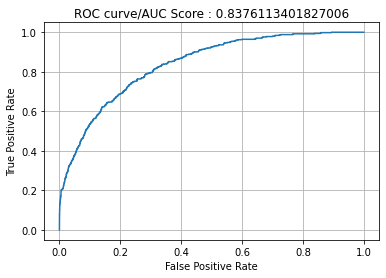

In [67]:
fig = plt.figure()

fpr,tpr,thresholds = roc_curve(va_y,val_pred)
auc_score = roc_auc_score(va_y,val_pred)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve/AUC Score : {auc_score}')

plt.grid(True)

In [68]:
# 重要度の上位を出力する
fscore = model.get_score(importance_type ='total_gain')
fscore = sorted([ (k, v ) for k, v in fscore.items()], key = lambda tpl: [1], reverse=True)
print('xgboost immportance')
print(fscore[:5])

xgboost immportance
[('success', 3365.337335331), ('housing', 2327.0039601906005), ('month', 2700.0153314215), ('age', 2028.9109545741976), ('balance', 2366.8172860527025)]


In [70]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,failure,other,success,score
0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,0,1,0,0.0
1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,1,1,0,1.0
2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,1,1,0,1.0
3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,1,0,0,0.0
4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,1,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,1,1,1,0,26661,1,0,0,27,7,345,4,425,0,1,1,0,0.0
27096,35,7,1,1,0,42150,1,0,0,27,7,121,1,719,0,1,1,0,0.0
27097,35,7,1,3,0,34531,0,0,0,28,5,177,2,121,0,1,1,0,1.0
27098,30,0,2,1,0,99621,1,0,0,27,7,121,1,100,0,1,1,0,1.0


In [73]:
score = test['score']
test = test.drop(['score'],axis=1)
test['score'] = score

In [75]:
d_test = xgb.DMatrix(test)
test_pred = model.predict(d_test, ntree_limit=model.best_ntree_limit)

In [78]:
test_tmp = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\unknown_poutcome\\test.csv')

In [80]:
# 出力用のデータの作成
id = test_tmp['id']
test_pred = pd.Series(test_pred)
pred = test_pred

submit = pd.concat([id,pred], axis=1)
submit.columns = ['id', 'y']
submit

,id,y
0,0,0.107577
1,1,0.063217
2,2,0.017855
3,3,0.001679
4,4,0.059148
...,...,...
18045,18045,0.037503
18046,18046,0.008155
18047,18047,0.134442
18048,18048,0.001195


In [81]:
# 提出用
submit.to_csv('xgboost_unknown_poutcome_umsamble.csv',index=False,header=False)